In [18]:
import pandas as pd

dtype_map = {
    'NCESDistrictID': 'string',
    'NCESSchoolID': 'string',
    'StateAssignedDistID': 'string',
    'Flag_AssmtNameChange': 'string',
    'Flag_CutScoreChange_ELA': 'string',
    'Flag_CutScoreChange_math': 'string',
    'Flag_CutScoreChange_sci': 'string',
    'Flag_CutScoreChange_soc': 'string',
    'DistType': 'string',
    'DistCharter': 'string',
    'DistLocale': 'string',
    'SchType': 'string',
    'SchLevel': 'string',
    'SchVirtual': 'string',
    # Add more as needed
}

df = pd.read_csv("data/merged_df_clean.csv", dtype=dtype_map, low_memory=False)


# Step 2: Ensure numeric columns are properly parsed
numeric_cols = [
    'Per Pupil Expenditure', 'AvgScaleScore', 'Year_final',
    'StudentGroup_TotalTested', 'StudentSubGroup_TotalTested',
    'Lev1_percent', 'Lev2_percent', 'Lev3_percent', 'Lev4_percent', 'Lev5_percent',
    'Lev1_count', 'Lev2_count', 'Lev3_count', 'Lev4_count', 'Lev5_count',
    'ProficientOrAbove_percent', 'ProficientOrAbove_count', 'ParticipationRate',
    'Grade_numeric'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 3: Clean and standardize string/categorical columns
str_cols = ['State', 'Subject', 'GradeLevel',
            'StudentGroup', 'DistName', 'SchName']
for col in str_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

df['Year_clean'] = df['SchYear_clean']

In [19]:
summary_df = df.groupby(['Subject', 'State'])
group_counts = summary_df.size().reset_index(name='count')
print(group_counts)

  Subject    State  count
0     ela  Arizona  23643
1     ela  Florida   3949
2     ela   Hawaii     48
3     ela  Indiana  22136
4    math  Arizona  23632
5    math  Florida   3939
6    math   Hawaii     48
7    math  Indiana  22135


As you can see only Florida uses AvgScaleScore (This looks like it is the data not an error when merging or reading)

In [20]:
def score_null_summary(df, df_name):
    # Force numeric: strings like '--' will become NaN
    scores = pd.to_numeric(df['AvgScaleScore'], errors='coerce')

    total_by_state = df.groupby('State').size().rename('total')
    nulls_by_state = scores.isna().groupby(df['State']).sum().rename('nulls')

    summary = pd.concat([total_by_state, nulls_by_state], axis=1)
    summary['non_null'] = summary['total'] - summary['nulls']
    summary['percent_null'] = (
        summary['nulls'] / summary['total'] * 100).round(1)
    summary['dataset'] = df_name
    return summary.reset_index()


# Run for both datasets
combined_summary = score_null_summary(df, 'df')
# Combine and display
comparison = pd.concat([combined_summary])
print(comparison.sort_values(['State', 'dataset']))

     State  total  nulls  non_null  percent_null dataset
0  Arizona  47275  47275         0         100.0      df
1  Florida   7888      1      7887           0.0      df
2   Hawaii     96     96         0         100.0      df
3  Indiana  44271  44271         0         100.0      df


Other metrics to use seem to be mostly ok but the states are not all equal ... keep that in mind

In [21]:
def test_column_validity_by_state(df, col_list):
    all_states = sorted(df['State'].dropna().unique())

    for state in all_states:
        print(f"\n🔎 State: {state}")
        state_df = df[df['State'] == state]

        for col in col_list:
            exists = col in state_df.columns
            if exists:
                total = len(state_df)
                non_null = state_df[col].notna().sum()
                percent_non_null = (non_null / total * 100).round(1)
                float_vals = pd.to_numeric(
                    state_df[col], errors='coerce').dropna().map(type).eq(float).sum()
            else:
                total = non_null = float_vals = percent_non_null = 0
            print(f"  ✅ {col:<25} | exists: {exists:<5} | total: {total:<6} "
                  f"| non-nulls: {non_null:<6} | % non-null: {percent_non_null:>5}% | float values: {float_vals}")


proficiency_cols = ['ProficientOrAbove_percent']
level_cols = [f'Lev{i}_percent' for i in range(1, 6)]
test_column_validity_by_state(df, proficiency_cols + level_cols)


🔎 State: Arizona
  ✅ ProficientOrAbove_percent | exists: 1     | total: 47275  | non-nulls: 34690  | % non-null:  73.4% | float values: 34690
  ✅ Lev1_percent              | exists: 1     | total: 47275  | non-nulls: 31871  | % non-null:  67.4% | float values: 31871
  ✅ Lev2_percent              | exists: 1     | total: 47275  | non-nulls: 31316  | % non-null:  66.2% | float values: 31316
  ✅ Lev3_percent              | exists: 1     | total: 47275  | non-nulls: 27762  | % non-null:  58.7% | float values: 27762
  ✅ Lev4_percent              | exists: 1     | total: 47275  | non-nulls: 27756  | % non-null:  58.7% | float values: 27756
  ✅ Lev5_percent              | exists: 1     | total: 47275  | non-nulls: 0      | % non-null:   0.0% | float values: 0

🔎 State: Florida
  ✅ ProficientOrAbove_percent | exists: 1     | total: 7888   | non-nulls: 7887   | % non-null: 100.0% | float values: 7887
  ✅ Lev1_percent              | exists: 1     | total: 7888   | non-nulls: 7887   | % non-null

In [22]:
def test_column_validity_by_state(df, col_list):
    all_states = sorted(df['State'].dropna().unique())

    for state in all_states:
        state_df = df[
            (df['State'] == state) &
            (pd.to_numeric(df['Per Pupil Expenditure'],
             errors='coerce').notna())
        ]

        print(
            f"\n🔎 State: {state} (with valid Per Pupil Expenditure only — {len(state_df)} rows)")

        for col in col_list:
            exists = col in state_df.columns
            if exists:
                total = len(state_df)
                non_null = state_df[col].notna().sum()
                percent_non_null = (non_null / total *
                                    100).round(1) if total > 0 else 0
                float_vals = pd.to_numeric(
                    state_df[col], errors='coerce').dropna().map(type).eq(float).sum()
            else:
                total = non_null = float_vals = percent_non_null = 0
            print(f"  ✅ {col:<25} | exists: {exists:<5} | total: {total:<6} "
                  f"| non-nulls: {non_null:<6} | % non-null: {percent_non_null:>5}% | float values: {float_vals}")


proficiency_cols = ['ProficientOrAbove_percent']
level_cols = [f'Lev{i}_percent' for i in range(1, 6)]
test_column_validity_by_state(df, proficiency_cols + level_cols)


🔎 State: Arizona (with valid Per Pupil Expenditure only — 14 rows)
  ✅ ProficientOrAbove_percent | exists: 1     | total: 14     | non-nulls: 2      | % non-null:  14.3% | float values: 2
  ✅ Lev1_percent              | exists: 1     | total: 14     | non-nulls: 2      | % non-null:  14.3% | float values: 2
  ✅ Lev2_percent              | exists: 1     | total: 14     | non-nulls: 2      | % non-null:  14.3% | float values: 2
  ✅ Lev3_percent              | exists: 1     | total: 14     | non-nulls: 1      | % non-null:   7.1% | float values: 1
  ✅ Lev4_percent              | exists: 1     | total: 14     | non-nulls: 1      | % non-null:   7.1% | float values: 1
  ✅ Lev5_percent              | exists: 1     | total: 14     | non-nulls: 0      | % non-null:   0.0% | float values: 0

🔎 State: Florida (with valid Per Pupil Expenditure only — 2158 rows)
  ✅ ProficientOrAbove_percent | exists: 1     | total: 2158   | non-nulls: 2158   | % non-null: 100.0% | float values: 2158
  ✅ Lev1_per

In [23]:
def test_proficient_by_state_and_year(df):
    # Ensure PPE is numeric
    df['Per Pupil Expenditure'] = pd.to_numeric(
        df['Per Pupil Expenditure'], errors='coerce')
    df['ProficientOrAbove_percent'] = pd.to_numeric(
        df['ProficientOrAbove_percent'], errors='coerce')
    df['Year_clean'] = pd.to_numeric(df['Year_clean'], errors='coerce')

    # Filter to rows with valid PPE and Year
    df_filtered = df[
        df['Per Pupil Expenditure'].notna() &
        df['Year_clean'].notna()
    ].copy()

    # Group by state and year
    grouped = (
        df_filtered
        .groupby(['State', 'Year_clean'])['ProficientOrAbove_percent']
        .agg([
            ('total', 'count'),
            ('non_null', lambda x: x.notna().sum()),
            ('float_vals', lambda x: pd.to_numeric(
                x, errors='coerce').dropna().map(type).eq(float).sum())
        ])
        .reset_index()
    )

    grouped['percent_non_null'] = (
        grouped['non_null'] / grouped['total'] * 100).round(1)

    # Pretty print
    for _, row in grouped.iterrows():
        print(f"🔎 State: {row['State']:<10} | Year: {int(row['Year_clean'])} | total: {row['total']:<5} "
              f"| non-nulls: {row['non_null']:<5} | % non-null: {row['percent_non_null']:>5.1f}% | float values: {row['float_vals']}")


test_proficient_by_state_and_year(df)

🔎 State: Arizona    | Year: 2015 | total: 2     | non-nulls: 2     | % non-null: 100.0% | float values: 2
🔎 State: Florida    | Year: 2015 | total: 360   | non-nulls: 360   | % non-null: 100.0% | float values: 360
🔎 State: Florida    | Year: 2016 | total: 360   | non-nulls: 360   | % non-null: 100.0% | float values: 360
🔎 State: Florida    | Year: 2017 | total: 359   | non-nulls: 359   | % non-null: 100.0% | float values: 359
🔎 State: Florida    | Year: 2018 | total: 360   | non-nulls: 360   | % non-null: 100.0% | float values: 360
🔎 State: Florida    | Year: 2020 | total: 359   | non-nulls: 359   | % non-null: 100.0% | float values: 359
🔎 State: Florida    | Year: 2021 | total: 360   | non-nulls: 360   | % non-null: 100.0% | float values: 360
🔎 State: Hawaii     | Year: 2015 | total: 12    | non-nulls: 12    | % non-null: 100.0% | float values: 12
🔎 State: Hawaii     | Year: 2016 | total: 12    | non-nulls: 12    | % non-null: 100.0% | float values: 12
🔎 State: Hawaii     | Year: 2017

In [24]:
# Clean GradeLevel
df['GradeLevel'] = df['GradeLevel'].astype(str).str.strip()
df['State'] = df['State'].astype(str).str.strip()

# Count per state
gradelevel_by_state = (
    df.groupby('State')['GradeLevel']
    .agg(
        total='count',
        non_null=lambda x: x[x.notna() & (x != '') & (x != 'nan')].count()
    )
    .reset_index()
)

gradelevel_by_state['percent_non_null'] = (
    gradelevel_by_state['non_null'] / gradelevel_by_state['total'] * 100).round(1)

# Print results
for _, row in gradelevel_by_state.iterrows():
    print(f"🔎 {row['State']:<10} | total: {row['total']:<6} | non-null: {row['non_null']:<6} | % non-null: {row['percent_non_null']:>5.1f}%")

🔎 Arizona    | total: 47275  | non-null: 47275  | % non-null: 100.0%
🔎 Florida    | total: 7888   | non-null: 7888   | % non-null: 100.0%
🔎 Hawaii     | total: 96     | non-null: 96     | % non-null: 100.0%
🔎 Indiana    | total: 44271  | non-null: 44271  | % non-null: 100.0%


In [32]:
df.columns

Index(['State', 'StateAbbrev', 'StateFips', 'SchYear', 'DataLevel', 'DistName',
       'SchName', 'NCESDistrictID', 'StateAssignedDistID', 'NCESSchoolID',
       'StateAssignedSchID', 'AssmtName', 'AssmtType', 'Subject', 'GradeLevel',
       'StudentGroup', 'StudentGroup_TotalTested', 'StudentSubGroup',
       'StudentSubGroup_TotalTested', 'Lev1_count', 'Lev1_percent',
       'Lev2_count', 'Lev2_percent', 'Lev3_count', 'Lev3_percent',
       'Lev4_count', 'Lev4_percent', 'Lev5_count', 'Lev5_percent',
       'AvgScaleScore', 'ProficiencyCriteria', 'ProficientOrAbove_count',
       'ProficientOrAbove_percent', 'ParticipationRate',
       'Flag_AssmtNameChange', 'Flag_CutScoreChange_ELA',
       'Flag_CutScoreChange_math', 'Flag_CutScoreChange_sci',
       'Flag_CutScoreChange_soc', 'DistType', 'DistCharter', 'DistLocale',
       'SchType', 'SchLevel', 'SchVirtual', 'CountyName', 'CountyCode',
       'DistrictName_clean', 'SchYear_clean', 'Agency Name',
       'Agency ID - NCES Assigned 

In [39]:
# Get unique values for each column
unique_districts = df['DistName'].unique()
unique_years = df['Year_clean'].unique()
unique_subjects = df['Subject'].unique()
unique_grades = df['Grade_numeric'].unique()

# Print the unique values
print("Unique District numbers:", len(unique_districts))
print("Unique Years:", np.sort(unique_years))
print("Unique Test Subjects:", np.sort(unique_subjects))
print("Unique Grade Levels:", np.sort(unique_grades))

Unique District numbers: 1170
Unique Years: [2014 2015 2016 2017 2018 2020 2021 2022 2023]
Unique Test Subjects: ['ela' 'math']
Unique Grade Levels: [ 3.  4.  5.  6.  7.  8. 38.]


In [ ]:
# Filter the dataframe to only rows where 'Per Pupil Expenditure' is not null
filtered_df = df[pd.to_numeric(
    df['Per Pupil Expenditure'], errors='coerce').notna()]

# Get unique values from the filtered DataFrame
unique_districts = filtered_df['DistName'].unique()
unique_years = filtered_df['Year_clean'].unique()
unique_subjects = filtered_df['Subject'].unique()
unique_grades = filtered_df['Grade_numeric'].unique()

# Print the unique values
print("Unique District numbers:", len(unique_districts))
print("Unique Years:", np.sort(unique_years))
print("Unique Test Subjects:", np.sort(unique_subjects))
print("Unique Grade Levels:", np.sort(unique_grades))

Unique District numbers: 176
Unique Years: [2015 2016 2017 2018 2020 2021]
Unique Test Subjects: ['ela' 'math']
Unique Grade Levels: [ 3.  4.  5.  6.  7.  8. 38.]


Each row captures data from a specific school district for a particular year, test subject, and grade level. Some data may be missing

# Modeling


📘 Linear Regression for MATH (Florida Only, with Year & Grade Controls)
                            OLS Regression Results                            
Dep. Variable:          AvgScaleScore   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     748.3
Date:                Sat, 19 Apr 2025   Prob (F-statistic):          1.64e-262
Time:                        05:43:20   Log-Likelihood:                -3552.8
No. Observations:                1078   AIC:                             7114.
Df Residuals:                    1074   BIC:                             7133.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

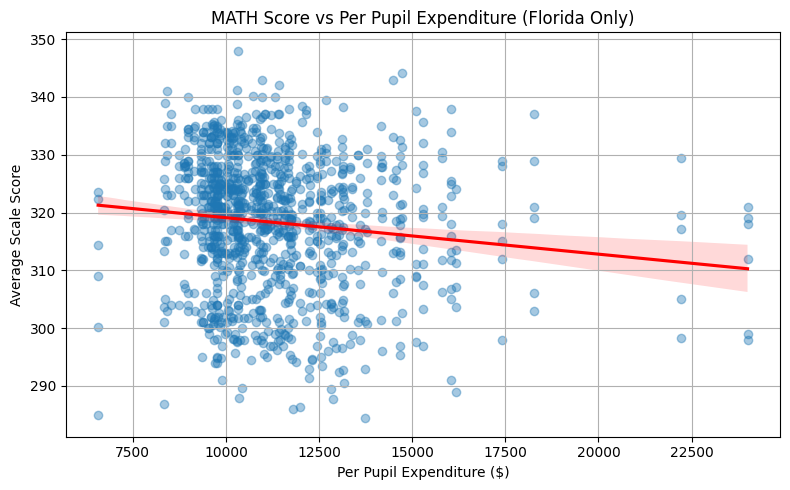


📘 Linear Regression for ELA (Florida Only, with Year & Grade Controls)
                            OLS Regression Results                            
Dep. Variable:          AvgScaleScore   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     1746.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:43:20   Log-Likelihood:                -3302.8
No. Observations:                1080   AIC:                             6614.
Df Residuals:                    1076   BIC:                             6633.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

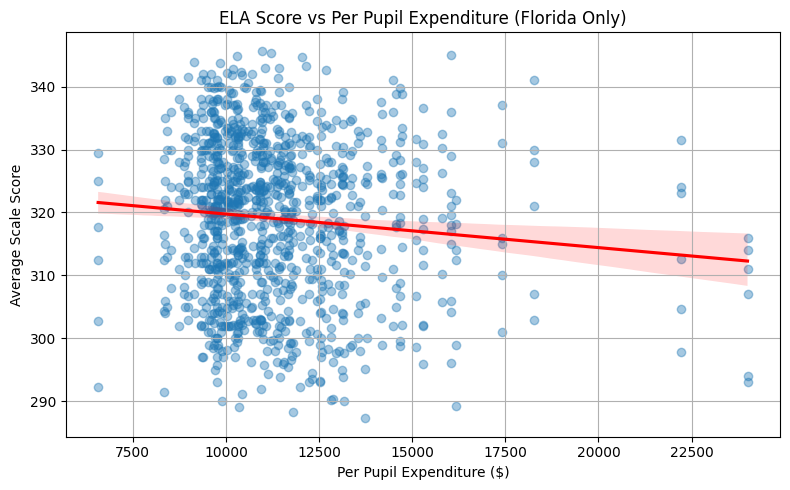

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 0: Filter to Florida only
florida_df = df[df['State'] == 'Florida'].copy()

# Step 1: Filter for math and ela, drop nulls
reg_df = florida_df[
    (florida_df['Per Pupil Expenditure'].notna()) &
    (florida_df['AvgScaleScore'].notna()) &
    (florida_df['Year_clean'].notna()) &
    (florida_df['Grade_numeric'].notna())
].copy()

# Step 2: Fit model separately for math and ela
for subject in ['math', 'ela']:
    print(
        f"\n📘 Linear Regression for {subject.upper()} (Florida Only, with Year & Grade Controls)")

    subj_df = reg_df[reg_df['Subject'] == subject].copy()

    X = subj_df[['Per Pupil Expenditure', 'Year_clean', 'Grade_numeric']]
    y = subj_df['AvgScaleScore']

    # Add constant
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Step 3: Plot unadjusted raw scatter + trend line
    plt.figure(figsize=(8, 5))
    sns.regplot(
        data=subj_df,
        x='Per Pupil Expenditure',
        y='AvgScaleScore',
        line_kws={'color': 'red'},
        scatter_kws={'alpha': 0.4}
    )
    plt.title(f'{subject.upper()} Score vs Per Pupil Expenditure (Florida Only)')
    plt.xlabel('Per Pupil Expenditure ($)')
    plt.ylabel('Average Scale Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Be carefull dropping data...

In [28]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Step 2: Filter valid rows
reg_df = df[
    df['Per Pupil Expenditure'].notna() &
    df['ProficientOrAbove_percent'].notna() &
    df['Grade_numeric'].notna() &
    df['Year_clean'].notna() &
    df['State'].notna()
].copy()

# Step 3: Create dummy variables for categorical columns
year_dummies = pd.get_dummies(reg_df['Year_clean'].astype(
    str), prefix='Year', drop_first=True)
grade_dummies = pd.get_dummies(reg_df['Grade_numeric'].astype(
    int).astype(str), prefix='Grade', drop_first=True)
state_dummies = pd.get_dummies(
    reg_df['State'], prefix='State', drop_first=True)

# Step 4: Build final X matrix
X = pd.concat([
    reg_df[['Per Pupil Expenditure']].reset_index(drop=True),
    year_dummies.reset_index(drop=True),
    grade_dummies.reset_index(drop=True),
    state_dummies.reset_index(drop=True)
], axis=1)

# Target variable
y = reg_df['ProficientOrAbove_percent'].reset_index(drop=True)

# Step 5: Clean final X and y
X = sm.add_constant(X).astype(float)
y = pd.to_numeric(y, errors='coerce').astype(float)

mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Step 6: Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     ProficientOrAbove_percent   R-squared:                       0.248
Model:                                   OLS   Adj. R-squared:                  0.247
Method:                        Least Squares   F-statistic:                     261.0
Date:                       Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                               05:37:44   Log-Likelihood:                 4545.7
No. Observations:                      11886   AIC:                            -9059.
Df Residuals:                          11870   BIC:                            -8941.
Df Model:                                 15                                         
Covariance Type:                   nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [49]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Step 2: Filter valid rows
reg_df = df[
    df['Per Pupil Expenditure'].notna() &
    df['ProficientOrAbove_percent'].notna() &
    df['Grade_numeric'].notna() &
    df['Year_clean'].notna() &
    df['State'].notna()
].copy()

# Step 3: Create dummies for categorical variables
year_dummies = pd.get_dummies(reg_df['Year_clean'].astype(
    str), prefix='Year', drop_first=True)
grade_dummies = pd.get_dummies(reg_df['Grade_numeric'].astype(
    int).astype(str), prefix='Grade', drop_first=True)
state_dummies = pd.get_dummies(
    reg_df['State'], prefix='State', drop_first=True)

# Step 4: Create interaction terms with PPE
ppe = reg_df[['Per Pupil Expenditure']].reset_index(drop=True)

ppe_x_year = ppe.values * year_dummies.values
ppe_x_grade = ppe.values * grade_dummies.values

ppe_x_year_df = pd.DataFrame(
    ppe_x_year, columns=[f'PPE_x_{col}' for col in year_dummies.columns])


# Step 5: Combine all features
X = pd.concat([
    sm.add_constant(ppe),         # base intercept and PPE
    year_dummies.reset_index(drop=True),
    grade_dummies.reset_index(drop=True),
    state_dummies.reset_index(drop=True),
    ppe_x_year_df,
], axis=1).astype(float)

# Target variable
y = reg_df['ProficientOrAbove_percent'].reset_index(drop=True).astype(float)

# Drop any remaining NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Step 6: Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     ProficientOrAbove_percent   R-squared:                       0.251
Model:                                   OLS   Adj. R-squared:                  0.250
Method:                        Least Squares   F-statistic:                     198.9
Date:                       Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                               21:29:11   Log-Likelihood:                 4570.3
No. Observations:                      11886   AIC:                            -9099.
Df Residuals:                          11865   BIC:                            -8944.
Df Model:                                 20                                         
Covariance Type:                   nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

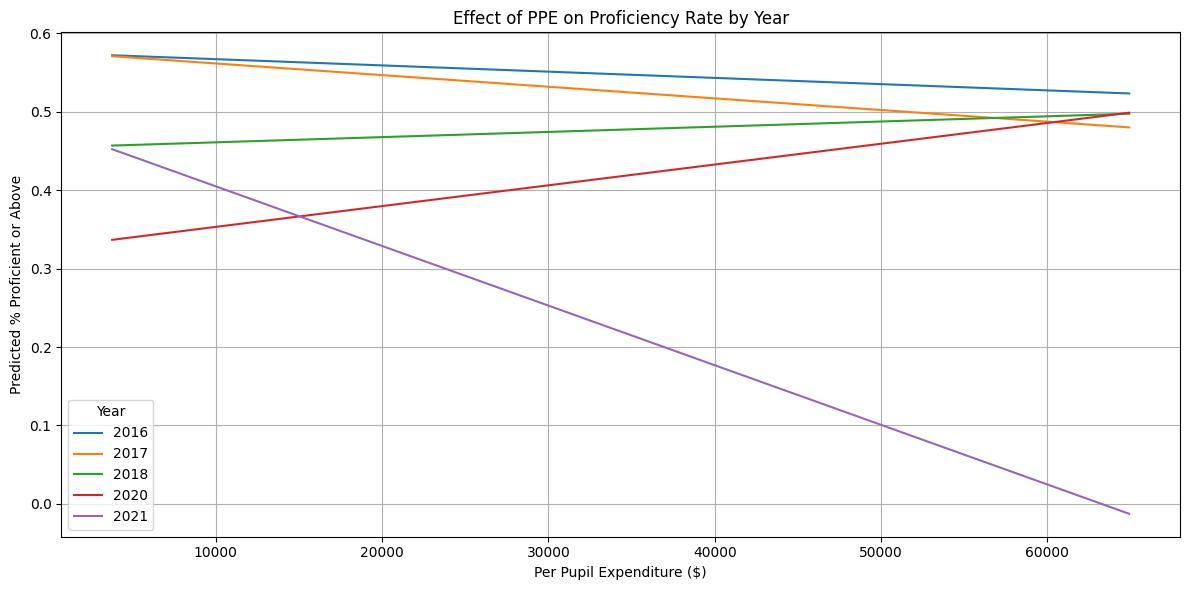

In [ ]:
import matplotlib.pyplot as plt

# Create PPE values to predict over
ppe_range = np.linspace(reg_df['Per Pupil Expenditure'].min(),
                        reg_df['Per Pupil Expenditure'].max(), 100)

# Use the first valid grade and state as reference
ref_grade = grade_dummies.columns[0]
ref_state = state_dummies.columns[0]

# Extract the list of years from the dummy columns
years = year_dummies.columns

# Initialize the plot
plt.figure(figsize=(12, 6))

for year_col in years:
    temp_df = pd.DataFrame({
        'const': 1,
        'Per Pupil Expenditure': ppe_range
    })

    # Add year dummies
    for col in years:
        temp_df[col] = 1 if col == year_col else 0

    # Add grade dummies
    for col in grade_dummies.columns:
        temp_df[col] = 1 if col == ref_grade else 0

    # Add state dummies
    for col in state_dummies.columns:
        temp_df[col] = 1 if col == ref_state else 0

    # Add interaction terms for year
    for col in years:
        interaction_col = f'PPE_x_{col}'
        temp_df[interaction_col] = (
            temp_df['Per Pupil Expenditure'] * temp_df[col]
        )

    # Add missing columns as 0
    for col in X.columns:
        if col not in temp_df.columns:
            temp_df[col] = 0

    # Reorder to match model
    temp_df = temp_df[X.columns]

    # Predict using fitted model
    y_pred = model.predict(temp_df)

    # Plot the prediction line
    label = year_col.replace("Year_", "")
    plt.plot(ppe_range, y_pred, label=label)

# Plot formatting
plt.xlabel("Per Pupil Expenditure ($)")
plt.ylabel("Predicted % Proficient or Above")
plt.title("Effect of PPE on Proficiency Rate by Year")
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()

# Great now we see that year 2021 durning covied schools that spend more actual had worse test socres (and a lot worse). 